# Python implementation of Deo 2015

I can't find any original code online for the model in the paper, so this is my python version of the model.

## $\delta$-function (Jäger 2007)

The $\delta$-function defines communicative success.

For a speaker strategy $S$, a hearer strategy $H$, and a state $t$, the success of $S$ conveying $t$ to $H$ is defined as $\delta$:

$$\delta_t = \begin{cases}
    1 & \text{if}\quad H(S(t)) = t\\
    0 & \text{otherwise}
    \end{cases}$$

## Utility functions

### First pass (Jäger 2007)
Speaker utility, where $k$ is some cost and $n$ is a function returning $j-1$ where $j$ is the number of expressions used by $S$ to convey the full range of meanings:

$$U_s(S, H, t) = \delta_t(S, H) - k \times n(S)$$

Hearer utility:

$$U_h(S, H, t) = \delta_t(S, H)$$

The average speaker and hearer utilities across states are given as:

$$U_s(S, H) = \sum_t P(t)\times(\delta_t(S, H)−k\times n(S))$$

$$U_h(S, H) = \sum_t P(t)\times(\delta_t(S, H))$$

### Contexts

She defines two contexts, $C_{phen}$ and $C_{struc}$, which have the following properties for the strategies $S_*$ in states **phen** and **struc**:

|  | $C_{phen}$: **phen** | $C_{phen}$: **struc** | $C_{struc}$: **phen** | $C_{struc}$: **struc** |
|:-:|:-:|:-:|:-:|:-:|
| $S_{cd}$ | impf | impf | impf | impf |
| $S_{pcd}$ | impf | impf | prog | impf |
| $S_{ed}$ | prog | impf | prog | impf |
| $S_{cd'}$ | prog | prog | prog | prog |

These are the hearer strategies given a context and an utterance:

|  |C-phen: *prog* | C-phen: *impf* | C-struc: *prog* | C-struc: *impf* |
|:-:|:-:|:-:|:-:|:-:|
| $H_{cd}$ | **phen** | **phen** | **struc** | **struc** |
| $H_{pcd}$ | **phen** | **phen** | **phen** | **struc** |
| $H_{ed}$ | **phen** | **struc** | **phen** | **struc** |

This gives us the following utility functions:

$$U_s(S, H) = \sum_c P(c) \times \sum_t P_c(t)\times(\delta_t(S, H)−k\times n(S))$$

$$U_h(S, H) = \sum c P(c) \times \sum_t P_c(t)\times(\delta_t(S, H))$$

### Expected utility (EU)

EU for a symmetrized game:

The idea: what happens when an individual with one grammar meets an individual with a different grammar:

$$\text{EU}(\langle S, H\rangle, \langle S', H'\rangle) = \frac{1}{2} \times (U_s(S, H') + U_h(S', H))$$

In [171]:
import numpy as np
import pandas as pd

states = ['phen', 'struc']
    
contexts = {'Cphen': 
               {'phen': 0.9,
               'struc': 0.1},
           'Cstruc':
               {'phen': 0.1,
               'struc': 0.9}}

speaker = {'Scd': {'Cphen': {'phen': 'impf', 'struc': 'impf'},
                  'Cstruc': {'phen': 'impf', 'struc': 'impf'}},
          'Spcd': {'Cphen': {'phen': 'impf', 'struc': 'impf'},
                  'Cstruc': {'phen': 'prog', 'struc': 'impf'}},
          'Sem': {'Cphen': {'phen': 'prog', 'struc': 'impf'},
                  'Cstruc': {'phen': 'prog', 'struc': 'impf'}},
          'Scd2': {'Cphen': {'phen': 'prog', 'struc': 'prog'},
                  'Cstruc': {'phen': 'prog', 'struc': 'prog'}}}

hearer = {'Hcd': {'Cphen': {'prog': 'phen', 'impf': 'phen'},
                  'Cstruc': {'prog': 'struc', 'impf': 'struc'}},
          'Hpcd': {'Cphen': {'prog': 'phen', 'impf': 'phen'},
                  'Cstruc': {'prog': 'phen', 'impf': 'struc'}},
          'Hem': {'Cphen': {'prog': 'phen', 'impf': 'struc'},
                  'Cstruc': {'prog': 'phen', 'impf': 'struc'}}}
k = 0.01

In [172]:
class AverageUtility:
    def __init__(self, states, contexts, speaker, hearer, k):
        self.states = states
        self.contexts = contexts
        self.speaker = speaker
        self.hearer = hearer
        self.k = k
    
    def delta(self, S, H, t):
        if H[S[t]] == t:
            return 1
        else:
            return 0
        
    def n(self, S):
        return len(set(S.values()))-1
        
    def U_s(self, S, H):
        a = 0
        for c in self.contexts:
            s = 0
            for t in self.states:
                s += self.contexts[c][t] * self.delta(self.speaker[S][c], self.hearer[H][c], t) \
                        - (self.k * self.n(self.speaker[S][c]))
            a += s * 0.5
        return a
    
    def U_h(self, S, H):
        a = 0
        for c in self.contexts:
            s = 0
            for t in self.states:
                s += self.contexts[c][t] * self.delta(self.speaker[S][c], self.hearer[H][c], t)
            a += s * 0.5
        return a
    
    def EU(self, S1, H1, S2, H2):
        return 0.5 * (self.U_s(S1, H2) + self.U_h(S2, H1))
    
    def EU_matrix(self):
        strat_prod = list(((x, y) for x in self.speaker.keys() for y in self.hearer.keys()))
        index = [', '.join(strat) for strat in strat_prod]
        matrix = pd.DataFrame(np.zeros((len(index), len(index))),
                              index=index, 
                              columns=index)
        for strat1 in strat_prod:
            for strat2 in strat_prod:
                matrix.loc[', '.join(strat1), ', '.join(strat2)] = self.EU(strat1[0], strat1[1], strat2[0], strat2[1])
        return matrix

In [223]:
average_utility = AverageUtility(states, contexts, speaker, hearer, k)
average_utility.EU_matrix()

,"Scd, Hcd","Scd, Hpcd","Scd, Hem","Spcd, Hcd","Spcd, Hpcd","Spcd, Hem","Sem, Hcd","Sem, Hpcd","Sem, Hem","Scd2, Hcd","Scd2, Hpcd","Scd2, Hem"
"Scd, Hcd",0.900,0.900,0.70,0.900,0.900,0.700,0.900,0.900,0.700,0.900,0.900,0.70
"Scd, Hpcd",0.900,0.900,0.70,0.925,0.925,0.725,0.925,0.925,0.725,0.700,0.700,0.50
"Scd, Hem",0.700,0.700,0.50,0.725,0.725,0.525,0.950,0.950,0.750,0.700,0.700,0.50
"Spcd, Hcd",0.895,0.920,0.72,0.895,0.920,0.720,0.895,0.920,0.720,0.895,0.920,0.72
"Spcd, Hpcd",0.895,0.920,0.72,0.920,0.945,0.745,0.920,0.945,0.745,0.695,0.720,0.52
"Spcd, Hem",0.695,0.720,0.52,0.720,0.745,0.545,0.945,0.970,0.770,0.695,0.720,0.52
"Sem, Hcd",0.890,0.915,0.94,0.890,0.915,0.940,0.890,0.915,0.940,0.890,0.915,0.94
"Sem, Hpcd",0.890,0.915,0.94,0.915,0.940,0.965,0.915,0.940,0.965,0.690,0.715,0.74
"Sem, Hem",0.690,0.715,0.74,0.715,0.740,0.765,0.940,0.965,0.990,0.690,0.715,0.74
"Scd2, Hcd",0.900,0.700,0.70,0.900,0.700,0.700,0.900,0.700,0.700,0.900,0.700,0.70


## The replicator–mutator dynamics

### The replicator

The strategies form a payoff matrix $X$ of shape $|S| \times |S|$, where $|S|$ is the number of strategies. The cell $X_{ij}$ is payoff of strategy $S_i$ interacting with strategy $S_j$.

We will say that the frequencies of strategies in a population is a vector $F$ of length $|S|$ where $F_i$ is the frequency of strategy $S_i$ in the population. 

The average payoffs for, or *fitness* of, a strategy $S_i$ for a given population composition, then, is just the dot product of the row vector $X_i$ and $F$. We'll call it $\vec f$.

The average fitness of the population $\phi$ at a given time is given as $\vec f \cdot F$, or the dot product of the average payoff for the individual strategies and their frequencies.

This allows us to define the subsequent frequency of a strategy A as:

$$x'_A = x_A\frac{f_A}{\phi}$$

Deo notes that this is the discrete time version, not a continuous version, which is likely what we want for a model of language change.

### The mutator

Now we need to account for mutation. This is represented as a row-stochastic matrix $Q$, which gives us the probability that a mutation occurs from one strategy to the next. The probability that one strategy $j$ mutates into a strategy $i$ is written as $Q_{ji}$

Deo provides the following replicator-mutator equation:

$$ x'_i = \sum^n_{j=1}Q_{ji}\frac{x_jf_j}{\phi}$$

Which can also be written using dot products, where the new frequencies are $F'$ and the operations in the fraction are element-wise:

$$F' = Q^\intercal \cdot \frac{F\vec f}{\phi}$$

In [350]:
class ReplicatorMutatorDynamics:
    def __init__(self, payoffs, frequencies, Q):
        self.payoffs = payoffs
        self.frequencies = frequencies
        self.Q = Q
    
    def replicator(self, payoffs, frequencies):
        average_payoffs = payoffs.dot(frequencies)
        average_fitness = average_payoffs.dot(frequencies)
        new_population = frequencies * average_payoffs / average_fitness
        return new_population
    
    def replicator_mutator(self, payoffs, frequencies, Q):
        average_payoffs = payoffs.dot(frequencies)
        average_fitness = average_payoffs.dot(frequencies)
        new_population = Q.T.dot(frequencies * average_payoffs) / average_fitness
        return new_population
    
    def run_dynamics(self, iterations):
        iteration = 0
        init_frequencies = self.frequencies
        payoffs = self.payoffs
        Q = self.Q
        frequencies = init_frequencies
        results = pd.DataFrame(index=range(0, iterations+1), columns=payoffs.columns)
        results.iloc[[0]] = np.zeros((1, len(payoffs.columns)))
        for i in range(iteration, iterations+1):
            frequencies = self.replicator_mutator(payoffs, frequencies, Q)
            results.iloc[i, :] = frequencies
        return results

### Initial replication

This replicates the results in section 5.3.1

First we'll try it with perfect learners.

In [310]:
test = ['Scd, Hcd', 'Spcd, Hpcd']
test_mat = average_utility.EU_matrix().loc[test, test]

In [311]:
frequencies = np.array([0.89, 0.11])
Q = np.array([[1, 0],
              [0, 1]])
replicator = ReplicatorMutatorDynamics(test_mat, frequencies, Q)

<AxesSubplot:>

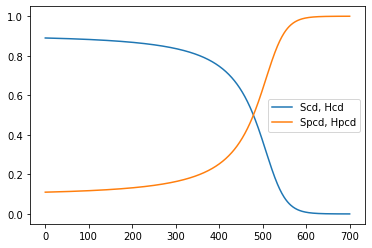

In [312]:
model1 = replicator.run_dynamics(700)
model.plot()

Now we'll try it with imperfect learners

<AxesSubplot:>

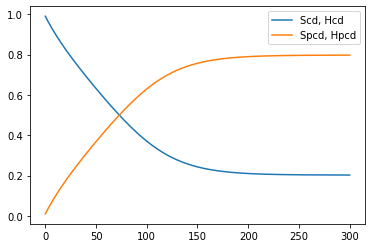

In [313]:
frequencies = np.array([1, 0])
Q = np.array([[0.99, 0.01],
              [0.01, 0.99]])
replicator2 = ReplicatorMutatorDynamics(test_mat, frequencies, Q)
model2 = replicator2.run_dynamics(300)
model2.plot()

So we've replicated her results.

### Replication of four strategies

Now we can try replicating the results with all four strategies.

The results will ultimately depend on how Q is defined.

<AxesSubplot:>

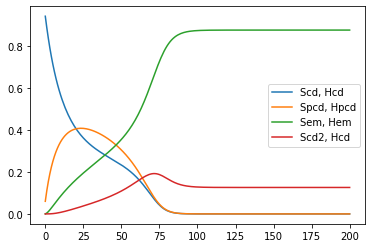

In [314]:
strategies = ['Scd, Hcd', 'Spcd, Hpcd', 'Sem, Hem', 'Scd2, Hcd']
payoff_matrix = average_utility.EU_matrix().loc[strategies, strategies]
frequencies = np.array([1, 0, 0, 0])
Q2 = np.array([[0.94, 0.06, 0, 0],
              [0.02, 0.91, 0.07, 0],
              [0, 0, 0.97, 0.03],
              [0, 0, 0, 1]])
replicator3 = ReplicatorMutatorDynamics(payoff_matrix, frequencies, Q2)
model3 = replicator3.run_dynamics(200)
model3.plot()

In the final model, she posits a Q that changes under certain conditions regarding the underlying frequencies of the strategies in the population. I'll maybe model it later, but I'm not sure that stipulating the change in Q is really sound given that she essentially justifies it on the basis of cost considerations, which should factor into the payoff matrix. 

## Experimenting with the model

It turns out that changing the cost has a *huge* effect on the results. By almost doubling the initial cost we get something resembing the final version of her model without having to posit that the mutation rates change at different population frequencies.

We can see that below where k=0.19. This same basic shape holds between 0.19~0.27, but outside of that range, we lose it. Even within that range, we see a lot of variation. If cost is 0, the basic shape looks like the categorical one that Deo posits.

If I had to guess why she doesn't go with k=~0.2, it's because the middle portion of the timeseries is pretty muddy and hard to interpret?

<AxesSubplot:>

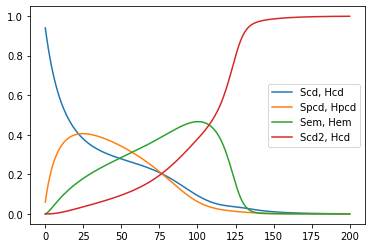

In [338]:
k2 = 0.019
average_utility = AverageUtility(states, contexts, speaker, hearer, k2)

strategies = ['Scd, Hcd', 'Spcd, Hpcd', 'Sem, Hem', 'Scd2, Hcd']
payoff_matrix = average_utility.EU_matrix().loc[strategies, strategies]
frequencies = np.array([1, 0, 0, 0])
Q2 = np.array([[0.94, 0.06, 0, 0],
              [0.02, 0.91, 0.07, 0],
              [0, 0, 0.97, 0.03],
              [0, 0, 0, 1]])

replicator = ReplicatorMutatorDynamics(payoff_matrix, frequencies, Q2)
model = replicator.run_dynamics(200)
model.plot()

Also, it looks like modulating the values of the Q matrix just a little bit has a huge effect. Shifting the probability density of the $S_{em}, H_{em}$ row just one point puts the prog categorical strategy into 100% in the limit. Something to consider.

<AxesSubplot:>

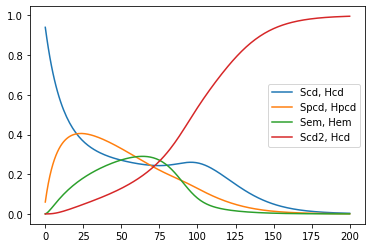

In [349]:
k2 = 0.01
average_utility = AverageUtility(states, contexts, speaker, hearer, k2)

strategies = ['Scd, Hcd', 'Spcd, Hpcd', 'Sem, Hem', 'Scd2, Hcd']
payoff_matrix = average_utility.EU_matrix().loc[strategies, strategies]
frequencies = np.array([1, 0, 0, 0])
Q2 = np.array([[0.94, 0.06, 0, 0],
              [0.02, 0.91, 0.07, 0],
              [0, 0, 0.96, 0.04],
              [0, 0, 0, 1]])

replicator = ReplicatorMutatorDynamics(payoff_matrix, frequencies, Q2)
model = replicator.run_dynamics(200)
model.plot()